In [1]:
type(lambda : None)

function

In [3]:
import random

In [ ]:
import torch
from math import exp
from random import random
from abc import ABC, abstractmethod
from copy import copy, deepcopy
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
from scipy.stats import wasserstein_distance
from numpy.polynomial.polynomial import Polynomial
from torch.distributions.normal import Normal
from torch.distributions.exponential import Exponential

from sympy import init_printing
import sympy.stats as ss
from sympy import Symbol, simplify, diff
import sympy

class Proposal(ABC):
    symmetric = False
    def sample(self, prev=None):
        pass

    def log_prob(self, x, prev=None):
        pass

    def __str__(self) -> str:
        pass


class MetropolisHastings:
    """
    Metropolis Hastings algorithm for sampling from a distribution p

    Attributes
    ----------
    p : distribution to sample from
    q : proposal distribution
    prev : previous sample
    """
    def __init__(self, p, q : Proposal):
        self.p = p
        self.q = q
        self.prev = None
        self.samples = []
    
    def _acceptance_prob(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x)
        if not isinstance(self.prev, torch.Tensor):
            self.prev = torch.tensor(self.prev)

        try:
            if not self.q.symmetric:
                a = self.p.log_prob(x) + self.q.log_prob(self.prev, x) - self.p.log_prob(self.prev) - self.q.log_prob(x, self.prev)
            else:
                a = self.p.log_prob(x) - self.p.log_prob(self.prev)
        except ValueError:
            return 0
        a = min(1, exp(a))
        return a        

    def _step(self):
        # Sample from q
        x = self.q.sample(self.prev)
        
        # Compute acceptance probability
        a = self._acceptance_prob(x)
        if a >= 1 or random() < a:
            self.prev = x

    def sample(self, n, x0, burnin=0, **kwargs):
        self.prev = x0
        for i in range(burnin):
            self._step()

        for i in range(n):
            self._step()
            self.samples.append(self.prev)
        return self.samples

    def _trace_plot(self, ax, **kwargs):
        ax.plot(self.samples)
        ax.set_title("Trace plot")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Sample value")
        return ax
    
    def _autocorrelation_plot(self, ax, **kwargs):
        ax.acorr(self.samples)
        ax.set_title("Autocorrelation plot")
        ax.set_xlabel("Lag")
        ax.set_ylabel("Autocorrelation")
        return ax
    
    def _wassterstein_distances(self, window_width = 100, **kwargs):
        w_dists = []
        target_samples = self.p.sample([len(self.samples)])

        for i in range(0 , len(self.samples) - window_width + 1, window_width):
            w_dists.append(wasserstein_distance(self.samples[i:i+window_width], target_samples[i:i+window_width]))
        return w_dists

    def _wasserstein_distance_plot(self, ax, window_width = 100, **kwargs):
        w_dists = self._wassterstein_distances(window_width, **kwargs)
        
        x_arr = np.arange(window_width - 1, len(self.samples), window_width)
        ax.plot(x_arr, w_dists, label="Wasserstein distance")

        # quadratic fit
        
        with np.printoptions(precision=2, suppress=True, formatter={'float_kind':'{:0.2f}'.format}):
            poly = Polynomial.fit(x_arr, w_dists, 1)
            ax.plot(x_arr, poly(x_arr), label=f"Linear fit: {poly.__str__()}")
            ax.set_title("Wasserstein distance plot")
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Wasserstein distance")
            ax.legend()

        return ax
    
    def plot(self, **kwargs):
        fig, axs = plt.subplots(2, 2, figsize=(15, 5))
        plot_funcs = [self._trace_plot, self._autocorrelation_plot, self._wasserstein_distance_plot]

        for ax, plot_func in zip(axs.flatten(), plot_funcs):
            plot_func(ax, **kwargs)
        
        plt.tight_layout()
        return axs
        

class IndependentGaussianProposal(Proposal):
    def __init__(self, mu, sigma):
        self.normal = Normal(mu, sigma)

    def log_prob(self, x, param=None):
        return self.normal.log_prob(x)
    
    def sample(self, prev=None):
        return self.normal.sample()
    
    def __str__(self) -> str:
        return "Independent Gaussian proposal"
    

class RandomWalkGaussianProposal(Proposal):
    def __init__(self, sigma):
        self.normal = Normal(0, sigma)
        self.symmetric = True

    def log_prob(self, x, prev):
        return self.normal.log_prob(x - prev)
    
    def sample(self, prev):
        return prev + self.normal.sample()
    
    def __str__(self) -> str:
        return "Random walk Gaussian proposal"


class AggregatePlotter:
    def sample(self, samples, repetitions, obj, window_width, **kwargs):
        self.window_width = window_width
        self.samples = samples
        self.store = []
        for i in range(repetitions):
            temp_obj = deepcopy(obj)
            temp_obj.sample(samples, **kwargs)
            self.store.append(temp_obj._wassterstein_distances(**kwargs))
        self.store = np.array(self.store)
    
    def plot(self):
        window_width = self.window_width
        print(window_width, self.samples, self.store.shape)
        x_arr = np.arange(window_width - 1, self.samples, window_width)
        mean_w_dists = np.mean(self.store, axis=0)
        print(x_arr.shape, mean_w_dists.shape)
        poly = Polynomial.fit(x_arr, mean_w_dists, 1)
        
        plt.plot(mean_w_dists)
        plt.plot(x_arr, poly(x_arr), label=f"Linear fit: {poly.__str__()}")


class Mixture:
    def __init__(self, distributions, weights=None):
        self.distributions = distributions
        self.weights = np.ones(len(distributions)) / len(distributions) if weights is None else np.array(weights) / sum(weights)

        if all([isinstance(d, Normal) for d in self.distributions]):
            means = [float(d.mean) for d in self.distributions]
            stds = [float(d.stddev) for d in self.distributions]

            densities = [ss.density(ss.Normal("x", mean, std))(Symbol("x")) for mean, std in zip(means, stds)]
            expr = 0
            for d, w in zip(densities, self.weights):
                expr += d * w
            log_expr = sympy.log(expr).simplify()
            grad = diff(log_expr, Symbol("x")).simplify()
            self.score = sympy.utilities.lambdify(Symbol("x"), grad, "numpy")
        else:
            self.score = None
    
    def sample(self, n):
        counts = np.random.multinomial(n[0], self.weights)
        out = np.concatenate([d.sample([c]) for d, c in zip(self.distributions, counts)])
        np.random.shuffle(out)
        return out
    
    def log_prob(self, x):
        log_probs = np.array([d.log_prob(x) for d in self.distributions])
        probs = np.exp(log_probs)
        return np.log(np.sum(probs * self.weights))
    
    def plot_pdf(self, x_arr):
        plt.plot(x_arr, [np.exp(self.log_prob(x)) for x in x_arr])
        plt.title("pdf of target distribution")
    
    # def score(self, x):
    #     if self.grad is None:
    #         raise NotImplementedError("Gradient is not implemented for this distribution")
        
    #     return self.grad(x)

        

class MALA(Proposal):
    def __init__(self, lr, grad_log_prob, str_rep="MALA"):
        self.lr = lr
        self.grad_log_prob = grad_log_prob
        self.str_rep = str_rep
    
    def log_prob(self, x, prev):
        dist = Normal(prev + self.lr * self.grad_log_prob(prev), np.sqrt(self.lr * 2))
        return dist.log_prob(x)

    def sample(self, prev):
        dist = Normal(prev + self.lr * self.grad_log_prob(prev), np.sqrt(self.lr * 2))
        return dist.sample()
    
    def __str__(self) -> str:
        return self.str_rep
    

class ULA(MetropolisHastings):
    def _step(self):
        # Sample from q
        x = self.q.sample(self.prev)
        self.prev = x
    
    def _acceptance_prob(self, x):
        pass

    def __str__(self) -> str:
        return "ULA"


In [80]:
init_printing()

In [65]:
# def _plot_RandomWalk():
#     MH = MetropolisHastings(Mixture([Normal(-6, 1), Normal(-3, 1), Normal(0, 1)], 
#                                     [1, 2, 4]), RandomWalkGaussianProposal(1))
#     MH.sample(500, torch.tensor(-6))
#     MH.plot(window_width=20);
# _plot_RandomWalk()

In [66]:
exp1 = (ss.density(ss.Normal("x", -6, 1))(Symbol("x")) + ss.density(ss.Normal("x", -3, 1))(Symbol("x")) * 2 + ss.density(ss.Normal("x", 0, 1))(Symbol("x")) * 4) / 7
exp1 = sympy.log(exp1)
exp2 = diff(exp1, Symbol("x")).simplify()
grad = sympy.utilities.lambdify(Symbol("x"), exp2, "numpy")

In [72]:
grad(5)

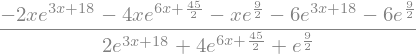

In [53]:
exp2

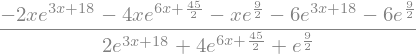

In [27]:
exp2

In [29]:
# def _plot_RandomWalk():
#     MH = MetropolisHastings(Mixture([Normal(-6, 1), Normal(-3, 1), Normal(0, 1)], 
#                                     [1, 2, 4]), MALA(1, grad))
#     MH.sample(500, torch.tensor(-6))
#     MH.plot(window_width=20);
# _plot_RandomWalk()

In [30]:
# def _plot_RandomWalk():
#     MH = MetropolisHastings(Mixture([Normal(-6, 1), Normal(-3, 1), Normal(0, 1)], 
#                                     [1, 2, 4]), IndependentGaussianProposal(-6, 1))
#     MH.sample(500, torch.tensor(-6))
#     MH.plot(window_width=20);
# _plot_RandomWalk()

In [81]:
class RepeatedSampler:
    def __init__(self, sampler_args, sampler=MetropolisHastings) -> None:
        self.sampler_args = sampler_args
        self.w_dists = None
        self.sampler = sampler
    
    def repeated_sample(self, repetitions, sample_length, x0=None, burnin=0, **kwargs):
        self.repetitions = repetitions
        self.samples = [self.sampler(**self.sampler_args) for _ in range(repetitions)]
        for i in range(repetitions):
            self.samples[i].sample(sample_length, x0, burnin, **kwargs)

    def _average_wassterstein_distance(self, window_width):
        w_dists = []
        
        for sample in self.samples:
            w_dists.append(sample._wassterstein_distances(window_width))
        w_dists = np.array(w_dists)
        self.w_dists = w_dists
        mean_w_dists = np.mean(w_dists, axis=0)

        return mean_w_dists
    
    def _plot_average_wassterstein_distance(self, window_width, a=None, ax=None, fit=False):
        if ax is None:
            ax = plt.gca()
        
        mean_w_dists = self._average_wassterstein_distance(window_width)
        x_arr = np.arange(window_width - 1, len(self.samples[0].samples), window_width)
        

        std_w_dists = np.std(self.w_dists, axis=0) / np.sqrt(self.repetitions)
        # plt.fill_between(x_arr, mean_w_dists - std_w_dists, mean_w_dists + std_w_dists, alpha=0.2)
        ax.plot(x_arr, mean_w_dists, label=self.sampler_args["q"].__str__())
        ax.fill_between(x_arr, mean_w_dists - std_w_dists, mean_w_dists + std_w_dists, alpha=0.2)

        if fit:
            poly = Polynomial.fit(x_arr, mean_w_dists, 1)
            ax.plot(x_arr, poly(x_arr), label=f"Linear fit: {poly.__str__()}")
        ax.set_title("Average Wasserstein distance plot")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("Wasserstein distance")
        ax.legend()

In [82]:
class RepeatedSamplerWrapper:
    def plot(self, repeated_samplers, sample_args, plot_args):
        fig, ax = plt.subplots()

        for sampler in repeated_samplers:
            sampler.repeated_sample(**sample_args)
            sampler._plot_average_wassterstein_distance(**plot_args, ax=ax)

In [83]:
Target_1 = Mixture([Normal(-6, 1), Normal(-3, 1), Normal(0, 1)], 
                                    [1, 2, 4])

(-1.0878556960509e-9*x*exp(3.0*x) - 0.00158699950546319*x*exp(6.0*x) - 0.285714285714286*x*exp(9.0*x) - 6.52713417630541e-9*exp(3.0*x) - 0.00476099851638956*exp(6.0*x))/(1.0878556960509e-9*exp(3.0*x) + 0.00158699950546319*exp(6.0*x) + 0.285714285714286*exp(9.0*x))


In [84]:
Target_1.score(5)

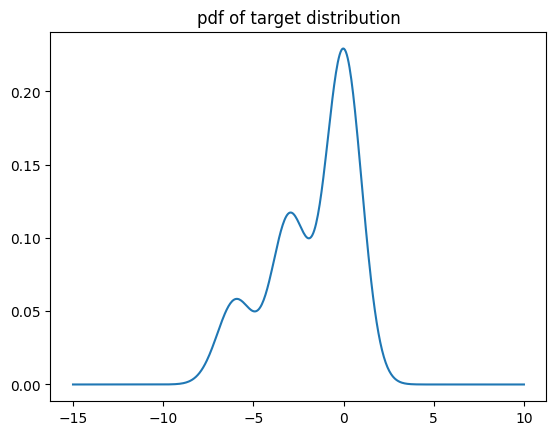

In [54]:
Target_1.plot_pdf(torch.tensor(np.linspace(-15, 10, 500)))

LATEST

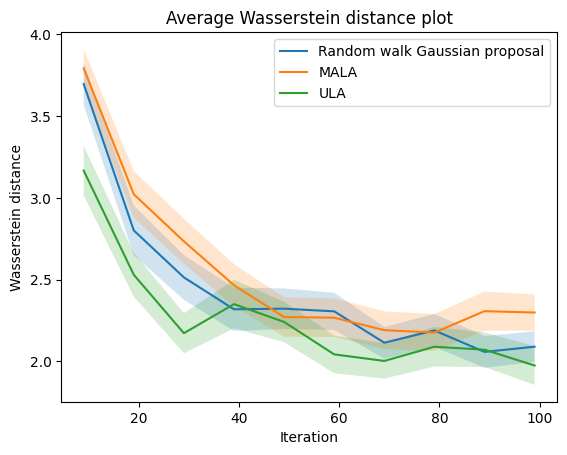

In [57]:
samplers = [
RepeatedSampler({"p":Target_1, "q": RandomWalkGaussianProposal(1)}),
RepeatedSampler({"p":Target_1, "q": MALA(1 / 2, Target_1.score)}),
RepeatedSampler({"p":Target_1, "q": MALA(1 / 2, Target_1.score, str_rep="ULA")}, sampler=ULA),
            ]


RepeatedSamplerWrapper().plot(samplers, sample_args={"repetitions": 100, "sample_length": 100, "x0": torch.tensor(-6), "burnin": 0}, 
                            plot_args={"window_width": 10})


In [ ]:
# samplers = [
# RepeatedSampler({"p":Mixture([Normal(-6, 1), Normal(-3, 1), Normal(0, 1)], 
#                                     [1, 2, 4]), "q": IndependentGaussianProposal(-6, 1)}),
# RepeatedSampler({"p":Mixture([Normal(-6, 1), Normal(-3, 1), Normal(0, 1)], 
#                                     [1, 2, 4]), "q": RandomWalkGaussianProposal(1)}),
# RepeatedSampler({"p":Mixture([Normal(-6, 1), Normal(-3, 1), Normal(0, 1)], 
#                                     [1, 2, 4]), "q": MALA(1 / 2, grad)})
#             ]


# RepeatedSamplerWrapper().plot(samplers, sample_args={"repetitions": 50, "sample_length": 250, "x0": torch.tensor(-6), "burnin": 0}, 
#                               plot_args={"window_width": 20})

BREAK

NEW

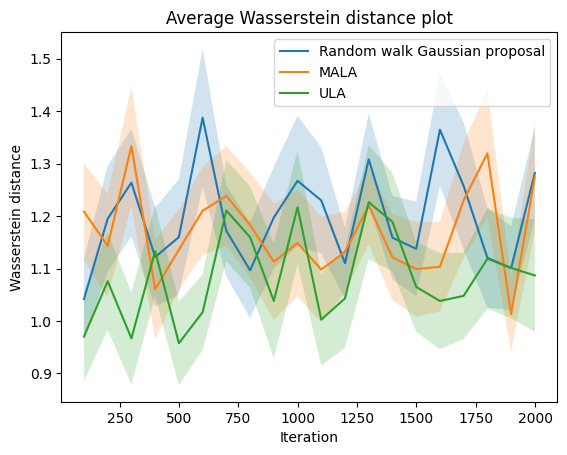

In [58]:
samplers = [
RepeatedSampler({"p":Target_1, "q": RandomWalkGaussianProposal(1)}),
RepeatedSampler({"p":Target_1, "q": MALA(1 / 2, Target_1.score)}),
RepeatedSampler({"p":Target_1, "q": MALA(1 / 2, Target_1.score, str_rep="ULA")}, sampler=ULA),
            ]

            

RepeatedSamplerWrapper().plot(samplers, sample_args={"repetitions": 50, "sample_length": 2000, "x0": torch.tensor(-6), "burnin": 100}, 
                              plot_args={"window_width": 100})

OLD

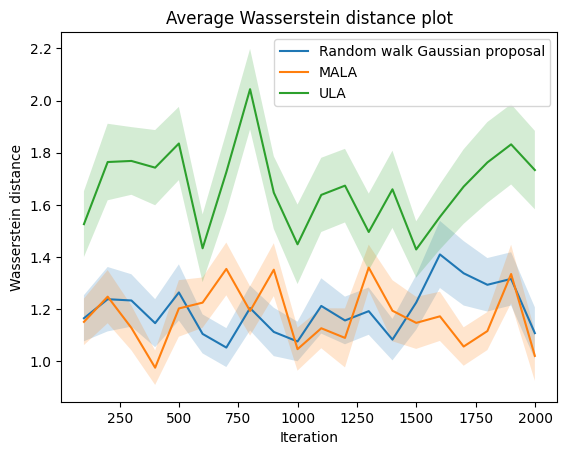

In [10]:
samplers = [
RepeatedSampler({"p":Target_1, "q": RandomWalkGaussianProposal(1)}),
RepeatedSampler({"p":Target_1, "q": MALA(1 / 2, grad)}),
RepeatedSampler({"p":Target_1, "q": MALA(1 / 2, grad, str_rep="ULA")}, sampler=ULA),
            ]

            

RepeatedSamplerWrapper().plot(samplers, sample_args={"repetitions": 50, "sample_length": 2000, "x0": torch.tensor(-6), "burnin": 100}, 
                              plot_args={"window_width": 100})

In [ ]:
# samplers = [
# RepeatedSampler({"p":Mixture([Normal(-6, 1), Normal(-3, 1), Normal(0, 1)], 
#                                     [1, 2, 4]), "q": IndependentGaussianProposal(-6, 1)}),
# RepeatedSampler({"p":Mixture([Normal(-6, 1), Normal(-3, 1), Normal(0, 1)], 
#                                     [1, 2, 4]), "q": RandomWalkGaussianProposal(1)}),
# RepeatedSampler({"p":Mixture([Normal(-6, 1), Normal(-3, 1), Normal(0, 1)], 
#                                     [1, 2, 4]), "q": MALA(1 / 2, grad)})
#             ]


# RepeatedSamplerWrapper().plot(samplers, sample_args={"repetitions": 50, "sample_length": 4000, "x0": torch.tensor(-6), "burnin": 500}, 
#                               plot_args={"window_width": 200})

[-8. -4.  0.] [1. 1. 1.] [0.14285714 0.28571429 0.57142857]
(-212.925571986607*x*exp(4.0*x) - 11280422422820.6*x*exp(8.0*x) - 6.7252934382977e+16*x*exp(12.0*x) - 1703.40457589286*exp(4.0*x) - 45121689691282.3*exp(8.0*x))/(212.925571986607*exp(4.0*x) + 11280422422820.6*exp(8.0*x) + 6.72529311056293e+16*exp(12.0*x)) grad
0.142857142857143*sqrt(2)*exp(-8.0*(0.25*x + 1)**2)/sqrt(pi) + 0.0714285714285714*sqrt(2)*exp(-32.0*(0.125*x + 1)**2)/sqrt(pi) + 0.285714285714286*sqrt(2)*exp(-0.5*x**2)/sqrt(pi) exp


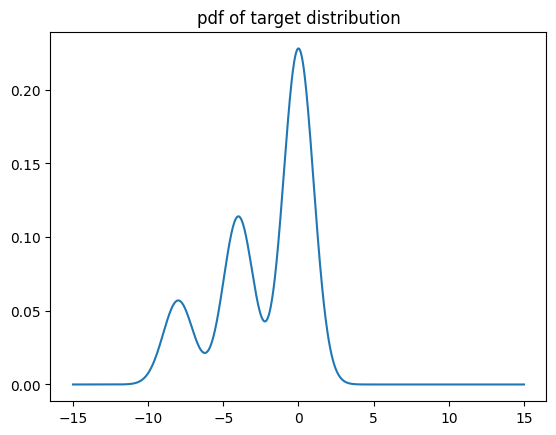

In [21]:
Target_2 = Mixture([Normal(-8, 1), Normal(-4, 1), Normal(0, 1)], [1, 2, 4])

Target_2.plot_pdf(torch.tensor(np.linspace(-15, 15, 1000)))

NEW

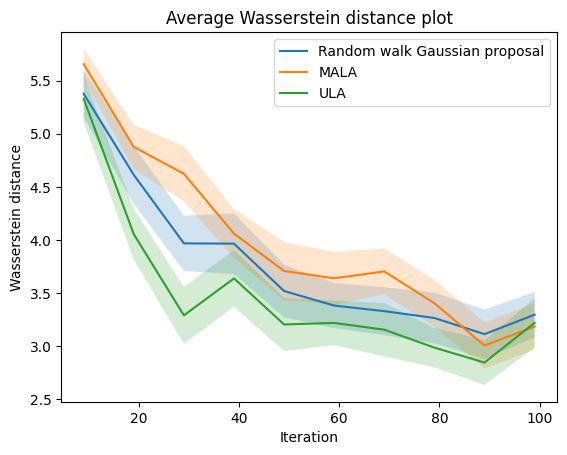

In [85]:
samplers = [
RepeatedSampler({"p":Target_2, "q": RandomWalkGaussianProposal(1)}),
RepeatedSampler({"p":Target_2, "q": MALA(1 / 2, Target_2.score)}),
RepeatedSampler({"p":Target_2, "q": MALA(1 / 2, Target_2.score, str_rep="ULA")}, sampler=ULA),
            ]


RepeatedSamplerWrapper().plot(samplers, sample_args={"repetitions": 50, "sample_length": 100, "x0": torch.tensor(-8), "burnin": 0}, 
                            plot_args={"window_width": 10})


NEW

KeyboardInterrupt: 

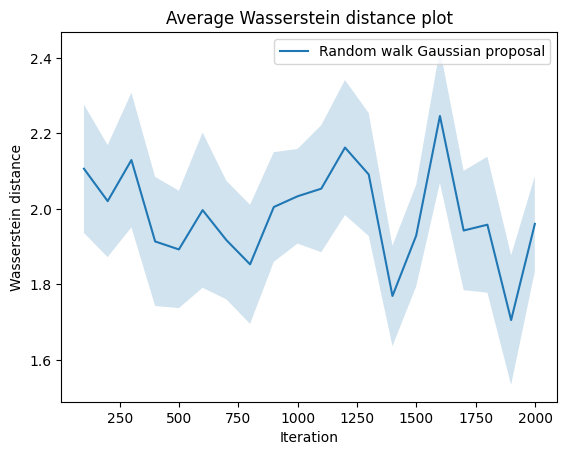

In [86]:
samplers = [
RepeatedSampler({"p":Target_2, "q": RandomWalkGaussianProposal(1)}),
RepeatedSampler({"p":Target_2, "q": MALA(1 / 2, Target_2.score)}),
RepeatedSampler({"p":Target_2, "q": MALA(1 / 2, Target_2.score, str_rep="ULA")}, sampler=ULA),
            ]

            
RepeatedSamplerWrapper().plot(samplers, sample_args={"repetitions": 50, "sample_length": 2000, "x0": torch.tensor(-10), "burnin": 100}, 
                              plot_args={"window_width": 100})

OLD

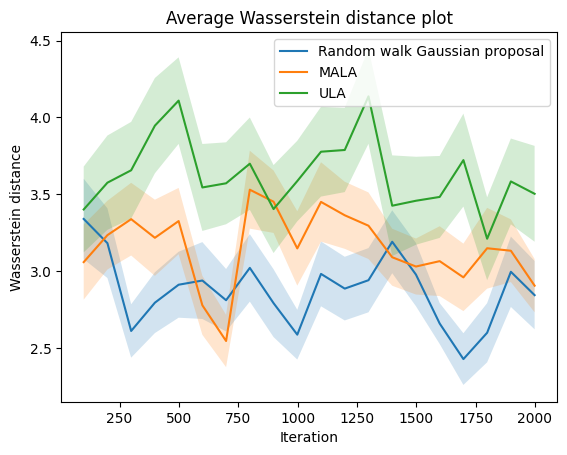

In [14]:
samplers = [
RepeatedSampler({"p":Target_2, "q": RandomWalkGaussianProposal(1)}),
RepeatedSampler({"p":Target_2, "q": MALA(1 / 2, grad)}),
RepeatedSampler({"p":Target_2, "q": MALA(1 / 2, grad, str_rep="ULA")}, sampler=ULA),
            ]

            
RepeatedSamplerWrapper().plot(samplers, sample_args={"repetitions": 50, "sample_length": 2000, "x0": torch.tensor(-6), "burnin": 100}, 
                              plot_args={"window_width": 100})

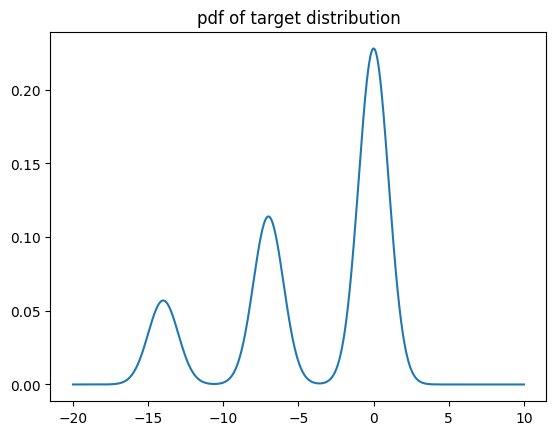

In [ ]:
Target_3 = Mixture([Normal(-14, 1), Normal(-7, 1), Normal(0, 1)], [1, 2, 4])

Target_3.plot_pdf(torch.tensor(np.linspace(-20, 10, 1000)))

In [85]:
# exp1 = (ss.density(ss.Normal("x", -14, 1))(Symbol("x")) + ss.density(ss.Normal("x", -7, 1))(Symbol("x")) + ss.density(ss.Normal("x", 0, 1))(Symbol("x"))) / 3
# sympy.log(exp1)
# exp2 = diff(sympy.log(exp1), Symbol("x")).simplify()
# grad = sympy.utilities.lambdify(Symbol("x"), exp2, "numpy")

NEW

<lambdifygenerated-17>:2: RuntimeWarning: overflow encountered in exp
  return (-3119513386.73207*x*exp(x*(1.0*x + 7.0)) - 5.19710168783375e+41*x*exp(x*(1.0*x + 14.0)) - 4.53947889186118e+52*x*exp(x*(1.0*x + 21.0)) - 43673185182.9994*exp(x*(1.0*x + 7.0)) - 3.63797099562081e+42*exp(x*(1.0*x + 14.0)))/(3119513014.85714*exp(1.0*x**2 + 7.0*x) + 5.19710106829102e+41*exp(1.0*x**2 + 14.0*x) + 4.5394788381773e+52*exp(1.0*x**2 + 21.0*x))


ValueError: Expected parameter loc (Tensor of shape ()) of distribution Normal(loc: nan, scale: 1.0) to satisfy the constraint Real(), but found invalid values:
nan

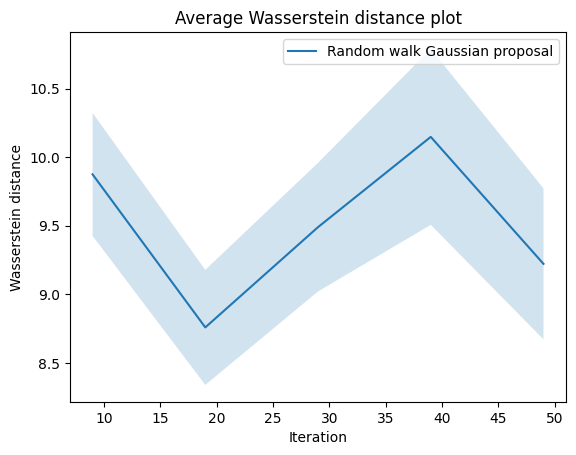

In [87]:
samplers = [
RepeatedSampler({"p":Target_3, "q": RandomWalkGaussianProposal(1)}),
RepeatedSampler({"p":Target_3, "q": MALA(1 / 2, Target_3.score)}),
RepeatedSampler({"p":Target_3, "q": MALA(1 / 2, Target_3.score, str_rep="ULA")}, sampler=ULA),
            ]


RepeatedSamplerWrapper().plot(samplers, sample_args={"repetitions": 20, "sample_length": 50, "x0": torch.tensor(-14), "burnin": 0}, 
                            plot_args={"window_width": 10})


OLD

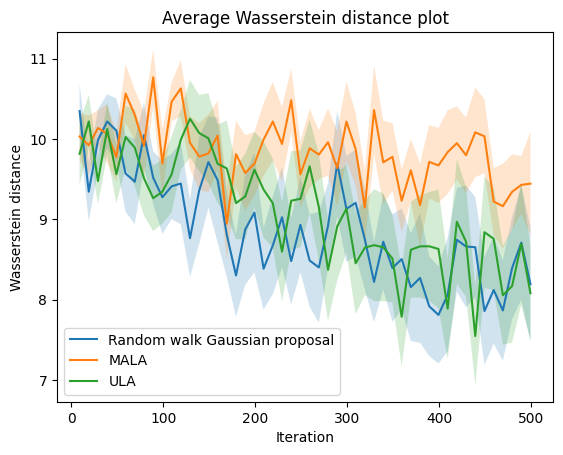

In [24]:
samplers = [
RepeatedSampler({"p":Target_3, "q": RandomWalkGaussianProposal(1)}),
RepeatedSampler({"p":Target_3, "q": MALA(1 / 2, grad)}),
RepeatedSampler({"p":Target_3, "q": MALA(1 / 2, grad, str_rep="ULA")}, sampler=ULA),
            ]


RepeatedSamplerWrapper().plot(samplers, sample_args={"repetitions": 20, "sample_length": 500, "x0": torch.tensor(-14), "burnin": 0}, 
                            plot_args={"window_width": 10})


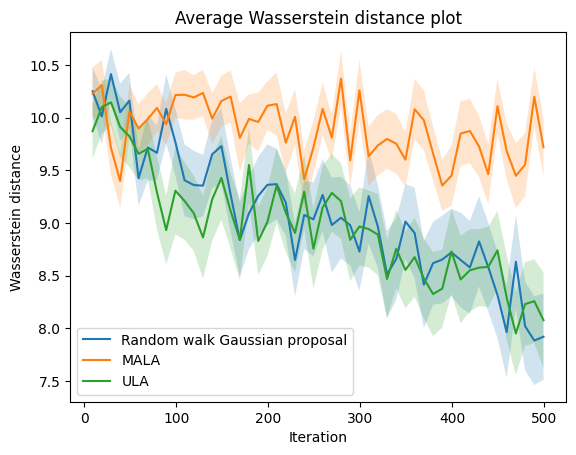

In [20]:
samplers = [
RepeatedSampler({"p":Target_3, "q": RandomWalkGaussianProposal(1)}),
RepeatedSampler({"p":Target_3, "q": MALA(1 / 2, grad)}),
RepeatedSampler({"p":Target_3, "q": MALA(1 / 2, grad, str_rep="ULA")}, sampler=ULA),
            ]


RepeatedSamplerWrapper().plot(samplers, sample_args={"repetitions": 50, "sample_length": 500, "x0": torch.tensor(-14), "burnin": 0}, 
                            plot_args={"window_width": 10})


NEW

In [ ]:
samplers = [
RepeatedSampler({"p":Target_3, "q": RandomWalkGaussianProposal(1)}),
RepeatedSampler({"p":Target_3, "q": MALA(1 / 2, Target_3.score)}),
RepeatedSampler({"p":Target_3, "q": MALA(1 / 2, Target_3.score, str_rep="ULA")}, sampler=ULA),
            ]


RepeatedSamplerWrapper().plot(samplers, sample_args={"repetitions": 20, "sample_length": 4000, "x0": torch.tensor(-14), "burnin": 500}, 
                            plot_args={"window_width": 200})


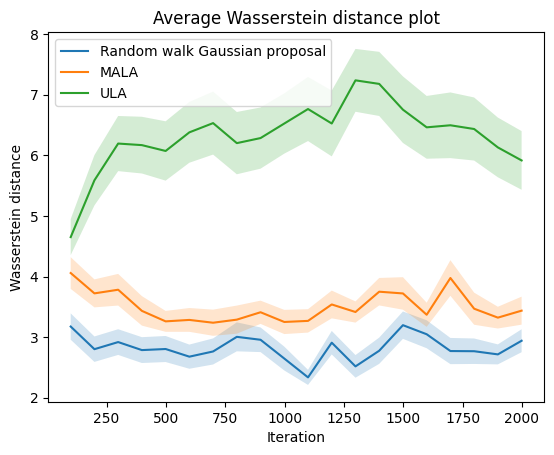

In [25]:
# samplers = [
# RepeatedSampler({"p":Target_2, "q": RandomWalkGaussianProposal(1)}),
# RepeatedSampler({"p":Target_2, "q": MALA(1 / 2, grad)}),
# RepeatedSampler({"p":Target_2, "q": MALA(1 / 2, grad, str_rep="ULA")}, sampler=ULA),
#             ]

            
# RepeatedSamplerWrapper().plot(samplers, sample_args={"repetitions": 50, "sample_length": 2000, "x0": torch.tensor(-6), "burnin": 100}, 
#                               plot_args={"window_width": 100})